In [1]:
import crocoddyl
import mujoco
import mujoco.viewer
import mim_solvers
import numpy as np
import matplotlib.pyplot as plt
import hppfcl
import time
np.set_printoptions(precision=4, linewidth=180)

import pin_utils, mpc_utils
import pinocchio as pin

from mim_robots.pybullet.env import BulletEnvWithGround
from mim_robots.robot_loader import load_bullet_wrapper, load_mujoco_model, get_robot_list, load_pinocchio_wrapper
from mim_robots.robot_list import MiM_Robots
from numpy.linalg import norm, solve
from scipy.spatial.transform import Rotation as R


pybullet build time: Nov 28 2023 23:45:17


In [2]:
def create_obs(pos, rot, m, d, num_obs):
    obsPose = pin.SE3.Identity()
    obsPose.rotation = rot
    obsPose.translation = pos
    obsObj = pin.GeometryObject("obstacle"+str(num_obs),
                                m.getFrameId("universe"),
                                m.frames[pin_model.getFrameId("universe")].parent,
                                hppfcl.Box(d[0], d[1], d[2]),
                                obsPose)
    return obsObj

def convert_2_cart(states, frame_id):
    size = states.shape
    cart_pred = np.zeros(shape = (size[0], size[1], 3))
    dummy_robot = load_pinocchio_wrapper("iiwa")
    m = dummy_robot.model
    d = dummy_robot.data
    for cycle in range(size[0]):
        for t in range(size[1]):
            q = states[cycle,t,:m.nq]
            v = states[cycle,t,m.nq:]
            pin.forwardKinematics(m,d,q)
            pin.framesForwardKinematics(m, d, q)
            pin.updateFramePlacements(m, d)  
            p = d.oMf[frame_id].copy()
            cart_pred[cycle,t,:] = p.translation

    return cart_pred

In [3]:
# Robot simulator Mujoco
RobotInfo = MiM_Robots["iiwa"]
mj_model = load_mujoco_model("iiwa")
mj_data = mujoco.MjData(mj_model)
robot_simulator = load_pinocchio_wrapper("iiwa")
pin_model = robot_simulator.model
pin_collision_model = robot_simulator.collision_model
pin_visual_model = robot_simulator.visual_model
pin_data = pin_model.createData()

In [4]:
# Extract robot model
nq = robot_simulator.model.nq
nv = robot_simulator.model.nv
nu = nq; nx = nq+nv
q0 = np.array([0.1, 0.7, 0., 0.7, -0.5, 1.5, 0.])
v0 = np.zeros(nv)
p0 = np.array([0.45, -0.3, 0.7])
oMdes = pin.SE3.Identity()
oMdes.rotation = R.from_euler('x', 180, degrees=True).as_matrix()
oMdes.translation = p0
idx = robot_simulator.index('A7')

In [5]:
eps    = 1e-4
IT_MAX = 1000
DT     = 1e0
damp   = 1e-6
# q = np.zeros(nq)
i = 1
while True:
    pin.forwardKinematics(pin_model,pin_data,q0)
    dMi = oMdes.actInv(pin_data.oMi[idx])
    err = pin.log(dMi).vector
    if norm(err) < eps:
        success = True
        break
    if i >= IT_MAX:
        success = False
        break
    J = pin.computeJointJacobian(pin_model,pin_data,q0,idx)
    v = - J.T.dot(solve(J.dot(J.T) + damp * np.eye(6), err))
    q0 = pin.integrate(pin_model,q0,v*DT)

pin.forwardKinematics(pin_model, pin_data, q0)
x0 = np.concatenate([q0, v0])
robot_simulator.forwardKinematics(q0, v0)
robot_simulator.computeJointJacobians(q0)
robot_simulator.framesForwardKinematics(q0)
robot_simulator.centroidalMomentum(q0, v0)

  f = 0 0 0
tau = 0 0 0

In [6]:
# Add robot to Mujoco and initialize
mj_renderer = mujoco.Renderer(mj_model)
mujoco.mj_step(mj_model, mj_data)
mj_renderer.update_scene(mj_data)
mj_data.qpos = q0
mj_data.qvel = v0
mujoco.mj_forward(mj_model, mj_data)
mj_dt=1e-3

In [7]:
# # # # # # # # # # # # # # #
###  SETUP CROCODDYL OCP  ###
# # # # # # # # # # # # # # #
# State and actuation model
state = crocoddyl.StateMultibody(robot_simulator.model)
actuation = crocoddyl.ActuationModelFull(state)
# Running and terminal cost models
runningCostModel = crocoddyl.CostModelSum(state)
terminalCostModel = crocoddyl.CostModelSum(state)
# Create cost terms 
# COLLISION COST 
# Create a capsule for the arm
link_names = ["A1", "A2", "A3", "A4", "A5", "A6", "A7"]
ig_link_names = []
# geomModel = pin.buildGeomFromUrdf(pin_model, MiM_Robots["iiwa"].urdf_path, pin.GeometryType.COLLISION, MiM_Robots["iiwa"].mesh_dir)
# geomModel.removeAllCollisionPairs()
pin_joint_ids = []
geomModel           = pin.GeometryModel() 
for i,ln in enumerate(link_names):
    pin_link_id         = pin_model.getFrameId(ln)
    pin_joint_id        = pin_model.getJointId(ln)
    pin_joint_ids.append(pin_joint_id)
    ig_link_names.append(geomModel.addGeometryObject(pin.GeometryObject("arm_link_"+str(i), 
                                                      pin_link_id, 
                                                      pin_model.frames[pin_model.getFrameId(ln)].parent,
                                                      hppfcl.Capsule(0, 0.5),
                                                      pin.SE3.Identity())))
    # if i > 0:
    #     geomModel.addCollisionPair(pin.CollisionPair(ig_link_names[i],ig_link_names[i-1]))
# print("num collision pairs - after addition:",len(geomModel.collisionPairs))

In [8]:
# Create obstacles in the world
obs_num = 2
obs_p = []
obs_p.append(np.array([0.50, -0.05, 0.6]))
obs_p.append(np.array([0.50, 0.2, 0.5]))
for i,p in enumerate(obs_p):
    obsObj = create_obs(p, pin.SE3.Identity().rotation, pin_model, [0.1]*3, i)
    ig_obs = geomModel.addGeometryObject(obsObj)
    for j in ig_link_names[4:]:
        geomModel.addCollisionPair(pin.CollisionPair(ig_link_names[j],ig_obs))


print("num collision pairs - after obstacles:",len(geomModel.collisionPairs))

num collision pairs - after obstacles: 6


In [9]:
# Control regularization cost
uResidual = crocoddyl.ResidualModelControlGrav(state)
uRegCost = crocoddyl.CostModelResidual(state, uResidual)
# State regularization cost
xResidual = crocoddyl.ResidualModelState(state, x0)
xRegCost = crocoddyl.CostModelResidual(state, xResidual)
# endeff frame translation cost
endeff_frame_id = pin_model.getFrameId("contact")
endeff_joint_id = pin_model.getJointId("contact")
endeff_translation = pin_data.oMf[endeff_frame_id].translation.copy()
# endeff_translation = np.array([-0.4, 0.3, 0.7]) # move endeff +10 cm along x in WORLD frame
endeff_translation = np.array([0.45, 0.4, 0.5])
frameTranslationResidual = crocoddyl.ResidualModelFrameTranslation(state, endeff_frame_id, endeff_translation)
frameTranslationCost = crocoddyl.CostModelResidual(state, frameTranslationResidual)

In [10]:
w = {
   'running_stateReg': 1e-1,
   'running_ctrlRegGrav': 1e-4,
   'running_translation': 100,
   'running_collision': 1000,
   'terminal_stateReg': 1e-1,
   'terminal_translation': 100,
   'terminal_collision': 1000
}
# Building Cost Function
runningCostModel.addCost("stateReg", xRegCost, w['running_stateReg'])
runningCostModel.addCost("ctrlRegGrav", uRegCost, w['running_ctrlRegGrav'])
runningCostModel.addCost("translation", frameTranslationCost, w['running_translation'])
terminalCostModel.addCost("stateReg", xRegCost, w['terminal_stateReg'])
terminalCostModel.addCost("translation", frameTranslationCost, w['terminal_translation'])

In [11]:
# Add collision cost to the OCP 
collision_radius = 0.1
activationCollision = crocoddyl.ActivationModel2NormBarrier(3, collision_radius)
c = 0
for i in range(len(geomModel.collisionPairs)):
    for j in pin_joint_ids[4:]:
        residualCollision = crocoddyl.ResidualModelPairCollision(state, nu, geomModel, i, j)
        costCollision = crocoddyl.CostModelResidual(state, activationCollision, residualCollision)
        runningCostModel.addCost("collision"+str(c), costCollision, w['running_collision'])
        terminalCostModel.addCost("collision"+str(c), costCollision, w['terminal_collision'])
        c=c+1

In [12]:
# Create Differential Action Model (DAM), i.e. continuous dynamics and cost functions
running_DAM = crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, runningCostModel)
terminal_DAM = crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, terminalCostModel)

In [13]:
# Create Integrated Action Model (IAM), i.e. Euler integration of continuous dynamics and cost
dt = 1e-2
runningModel = crocoddyl.IntegratedActionModelEuler(running_DAM, dt)
terminalModel = crocoddyl.IntegratedActionModelEuler(terminal_DAM, 0.)

In [14]:
# Create the shooting problem
T = 50
problem = crocoddyl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [15]:
# Create solver + callbacks
solver = mim_solvers.SolverSQP(problem)
# solver.setCallbacks([crocoddyl.CallbackLogger(),
#                   crocoddyl.CallbackVerbose()])
# Warm start : initial state + gravity compensation
xs_init = [x0 for i in range(T+1)]
us_init = solver.problem.quasiStatic(xs_init[:-1])
# Solve
solver.termination_tolerance = 1e-4
solver.with_callbacks = True
solver.solve(xs_init, us_init, 100)
solver.with_callbacks = False

iter     merit         cost         grad      step    ||gaps||        KKT
   1  3.86705e+01  3.86705e+01  1.54996e+02  1.0000  1.88009e-14  3.15102e+01
   2  5.00894e+02  1.98850e+01  2.03002e+02  1.0000  4.81009e+02  1.38248e+01
   3  4.37254e+02  2.32468e+01  1.94821e+02  1.0000  4.14007e+02  2.19447e+01
   4  4.15253e+02  2.23573e+01  2.35222e+02  1.0000  3.92896e+02  3.56032e+01
   5  4.35784e+02  1.97770e+01  2.58289e+02  1.0000  4.16007e+02  1.85424e+01
   6  2.05148e+02  1.90910e+01  1.67807e+02  1.0000  1.86057e+02  1.29727e+02
   7  9.16329e+01  1.06331e+01  1.42831e+02  0.5000  8.09998e+01  6.66521e+00
   8  6.08178e+01  6.76263e+00  7.15329e+01  0.5000  5.40551e+01  4.87526e+00
   9  4.03072e+01  5.76570e+00  5.26413e+01  1.0000  3.45415e+01  2.43306e+01
  10  3.10949e+01  4.61221e+00  6.15313e+01  1.0000  2.64827e+01  2.56313e+00
iter     merit         cost         grad      step    ||gaps||        KKT
  11  3.82202e+01  4.03292e+00  1.28721e+01  1.0000  3.41873e+01  6.4351

In [112]:
# # # # # # # # # # # #
###  MPC SIMULATION ###
# # # # # # # # # # # #
# OCP parameters
ocp_params = {}
ocp_params['N_h']          = T
ocp_params['dt']           = dt
ocp_params['maxiter']      = 10 
ocp_params['nbody']        = 1
ocp_params['pin_model']    = robot_simulator.model
ocp_params['armature']     = runningModel.differential.armature
ocp_params['id_endeff']    = endeff_frame_id
ocp_params['active_costs'] = solver.problem.runningModels[0].differential.costs.active.tolist()
print(ocp_params['active_costs'])
# Simu parameters
sim_params = {}
# sim_params['sim_freq']  = int(1./env.dt)
sim_params['sim_freq']  = int(1./mj_dt)
sim_params['mpc_freq']  = 1000
sim_params['T_sim']     = 1.
log_rate = 100

# Initialize simulation data 
sim_data = mpc_utils.init_sim_data(sim_params, ocp_params, x0)

['collision0', 'collision1', 'collision10', 'collision11', 'collision12', 'collision13', 'collision14', 'collision15', 'collision16', 'collision17', 'collision2', 'collision3', 'collision4', 'collision5', 'collision6', 'collision7', 'collision8', 'collision9', 'ctrlRegGrav', 'stateReg', 'translation']

                       *************************
                       ** Simulation is ready **
                       *************************
-------------------------------------------------------------------
- Total simulation duration            : T_sim           = 1.0 s
- Simulation frequency                 : f_simu          = 1.0 kHz
- Replanning frequency                 : f_plan          = 1.0 kHz
- Total # of simulation steps          : N_sim           = 1000
- Total # of planning steps            : N_mpc           = 1000
- Duration of MPC horizon              : T_ocp           = 0.5 s
- OCP integration step                 : dt              = 0.01 s
-----------------------

/tmp/ipykernel_15548/2531898708.py:13: UserWarning: Deprecated. Use property active_set
  ocp_params['active_costs'] = solver.problem.runningModels[0].differential.costs.active.tolist()


In [156]:
# Correction Setup
apply_correction = True
correction = np.zeros(shape=(sim_data['N_sim']+1,pin_model.nq))
correction_joints = [3]
correction_torque = 75
corr_t_start = 300 # At which timestamp correction starts
corr_t_end = 800 # At which timestamp correction ends
if apply_correction:
    correction[corr_t_start:corr_t_end,correction_joints] = correction_torque

In [157]:
# Display target 
mj_data.qpos = q0
mj_data.qvel = np.zeros(sim_data['nq'])
# mpc_utils.display_ball(endeff_translation, RADIUS=.05, COLOR=[1.,0.,0.,.6])
Mujoco_view = True
if Mujoco_view:
    viewer = mujoco.viewer.launch_passive(mj_model, mj_data, show_left_ui=True, show_right_ui=True)
    viewer.user_scn.flags[mujoco.mjtRndFlag.mjRND_WIREFRAME] = 1
    viewer.user_scn.ngeom = obs_num+1
    for i,p in enumerate(obs_p):
        mujoco.mjv_initGeom(
                viewer.user_scn.geoms[i],
                type=mujoco.mjtGeom.mjGEOM_BOX,
                size=[0.05, 0.05, 0.05],
                pos=p,
                mat=np.eye(3).flatten(),
                rgba=np.array([1.,0.,0.,.5])
            )
    
    mujoco.mjv_initGeom(
              viewer.user_scn.geoms[viewer.user_scn.ngeom-1],
              type=mujoco.mjtGeom.mjGEOM_SPHERE,
              size=[0.05, 0.05, 0.05],
              pos=endeff_translation,
              mat=np.eye(3).flatten(),
              rgba=np.array([0.,1.,0.,.5])
          )
    viewer.sync()

In [158]:
mpc_cycle = 0
pert = []
pose = []
tau_ext = []
q_ddot = 0
q_dot_prev = 0
q_dot_curr = 0

for i in range(sim_data['N_sim']): 

    if(i%log_rate==0): 
        print("\n SIMU step "+str(i)+"/"+str(sim_data['N_sim'])+"\n")

    # Solve OCP if we are in a planning cycle (MPC/planning frequency)
    if(i%int(sim_params['sim_freq']/sim_params['mpc_freq']) == 0):
        # Set x0 to measured state 
        solver.problem.x0 = sim_data['state_mea_SIM_RATE'][i, :]
        # Warm start using previous solution
        xs_init = list(solver.xs[1:]) + [solver.xs[-1]]
        xs_init[0] = sim_data['state_mea_SIM_RATE'][i, :]
        us_init = list(solver.us[1:]) + [solver.us[-1]] 
        
        # Solve OCP & record MPC predictions
        solver.solve(xs_init, us_init, ocp_params['maxiter'])
        sim_data['state_pred'][mpc_cycle, :, :]  = np.array(solver.xs)
        sim_data['ctrl_pred'][mpc_cycle, :, :]   = np.array(solver.us)
        # Extract relevant predictions for interpolations
        x_curr = sim_data['state_pred'][mpc_cycle, 0, :]    # x0* = measured state    (q^,  v^ )
        x_pred = sim_data['state_pred'][mpc_cycle, 1, :]    # x1* = predicted state   (q1*, v1*) 
        u_curr = sim_data['ctrl_pred'][mpc_cycle, 0, :]     # u0* = optimal control   (tau0*)
        # Record costs references
        q = sim_data['state_pred'][mpc_cycle, 0, :sim_data['nq']]
        vq = sim_data['state_pred'][mpc_cycle, 0, sim_data['nq']:]; 
        sim_data['ctrl_ref'][mpc_cycle, :]       = pin_utils.get_u_grav(q, solver.problem.runningModels[0].differential.pinocchio, ocp_params['armature'])
        sim_data['state_ref'][mpc_cycle, :]      = solver.problem.runningModels[0].differential.costs.costs['stateReg'].cost.residual.reference
        sim_data['lin_pos_ee_ref'][mpc_cycle, :] = solver.problem.runningModels[0].differential.costs.costs['translation'].cost.residual.reference
        
        # Select reference control and state for the current MPC cycle
        x_ref_MPC_RATE  = x_curr + sim_data['ocp_to_mpc_ratio'] * (x_pred - x_curr)
        u_ref_MPC_RATE  = u_curr 
        if(mpc_cycle==0):
            sim_data['state_des_MPC_RATE'][mpc_cycle, :]   = x_curr  
        sim_data['ctrl_des_MPC_RATE'][mpc_cycle, :]    = u_ref_MPC_RATE   
        sim_data['state_des_MPC_RATE'][mpc_cycle+1, :] = x_ref_MPC_RATE    
        
        # Increment planning counter
        mpc_cycle += 1
        
        # Select reference control and state for the current SIMU cycle
        x_ref_SIM_RATE  = x_curr + sim_data['ocp_to_sim_ratio'] * (x_pred - x_curr)
        u_ref_SIM_RATE  = u_curr 

        # First prediction = measurement = initialization of MPC
        if(i==0):
            sim_data['state_des_SIM_RATE'][i, :]   = x_curr  
        sim_data['ctrl_des_SIM_RATE'][i, :]    = u_ref_SIM_RATE  
        sim_data['state_des_SIM_RATE'][i+1, :] = x_ref_SIM_RATE 

        # Send torque to simulator & step simulator
        # Mujoco Environment Update
        mj_data.ctrl = u_ref_SIM_RATE
        mj_data.qpos = x_ref_SIM_RATE[:sim_data['nq']]
        mj_data.qvel = x_ref_SIM_RATE[sim_data['nq']:]
        mujoco.mj_step(mj_model, mj_data)
        if Mujoco_view:
            viewer.sync()
            pert.append(viewer.perturb.active) # Record if a perturbation is applied manually in Mujoco

        # Apply correction
        mj_data.qfrc_applied = correction[mpc_cycle]

        # Compute External Torque
        q_dot_curr = vq
        q_ddot += (q_dot_curr - q_dot_prev)*mj_dt; 
        q_dot_prev = q_dot_curr
        b = pin.nle(pin_model, pin_data, mj_data.qpos, mj_data.qvel) # compute dynamic drift -- Coriolis, centrifugal, gravity
        M = pin.crba(pin_model, pin_data, mj_data.qpos) # compute mass matrix M
        tau_ext.append(- u_curr + (M.dot(q_ddot) + b))
        
        # Measure new state from Mujoco
        q_mea_SIM_RATE = mj_data.qpos
        v_mea_SIM_RATE = mj_data.qvel

        # Update pinocchio model
        pin.forwardKinematics(pin_model, pin_data, q_mea_SIM_RATE, v_mea_SIM_RATE)
        pin.computeJointJacobians(pin_model, pin_data, q_mea_SIM_RATE)
        pin.framesForwardKinematics(pin_model, pin_data, q_mea_SIM_RATE)
        pin.updateFramePlacements(pin_model, pin_data)  
        robot_simulator.centroidalMomentum(q_mea_SIM_RATE, v_mea_SIM_RATE)
        curr_pose = pin_data.oMf[endeff_frame_id].copy()
        pose.append(curr_pose.translation)

        # Record data 
        x_mea_SIM_RATE = np.concatenate([q_mea_SIM_RATE, v_mea_SIM_RATE]).T 
        sim_data['state_mea_SIM_RATE'][i+1, :] = x_mea_SIM_RATE
        # sim_data['force_x_app_SIM_RATE'][mpc_cycle, :] = mj_data.cfrc_ext


 SIMU step 0/1000


 SIMU step 100/1000


 SIMU step 200/1000


 SIMU step 300/1000


 SIMU step 400/1000


 SIMU step 500/1000


 SIMU step 600/1000


 SIMU step 700/1000


 SIMU step 800/1000


 SIMU step 900/1000



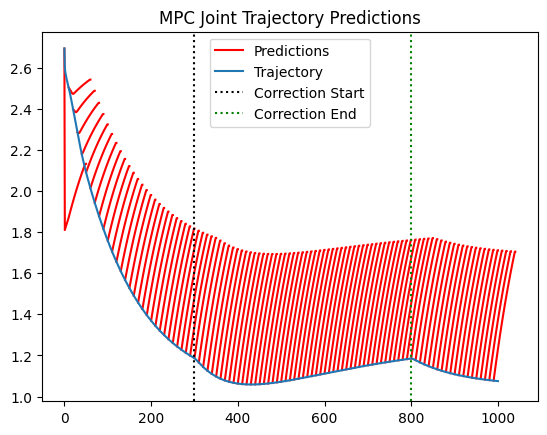

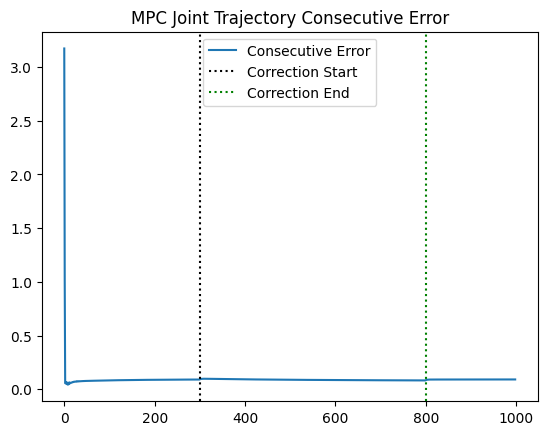

In [167]:
s_id = 6 # which state value to plot: [q, q_dot] from 0 to 13 

for i in range(mpc_cycle):
    if (i%10 == 0):
        t = np.linspace(i,i+T,T+1)
        if i == 0:
            plt.plot(t,sim_data['state_pred'][i,:,s_id],color='red')
        else:
            plt.plot(t,sim_data['state_pred'][i,:,s_id],color='red', label='_nolegend_')
plt.plot(sim_data['state_mea_SIM_RATE'][:,s_id])
if apply_correction:
    plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
    plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
    plt.legend(['Predictions', 'Trajectory','Correction Start','Correction End'])
else:
    plt.legend(['Predictions', 'Trajectory'])
plt.title('MPC Joint Trajectory Predictions')
plt.show()

diff_pred = []
for i in range(mpc_cycle-1):
    state_prev = sim_data['state_pred'][i,1:,s_id]
    state_curr = sim_data['state_pred'][i+1,:-1,s_id]
    diff_pred.append(np.linalg.norm(state_prev-state_curr))

diff_pred = np.stack(diff_pred)
plt.plot(diff_pred)
if apply_correction:
    plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
    plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
    plt.legend(['Consecutive Error','Correction Start','Correction End'])
else:
    plt.legend(['Consecutive Error'])
plt.title('MPC Joint Trajectory Consecutive Error')
plt.show()

In [160]:
sim_data['pose_pred'] = convert_2_cart(sim_data['state_pred'], endeff_frame_id)

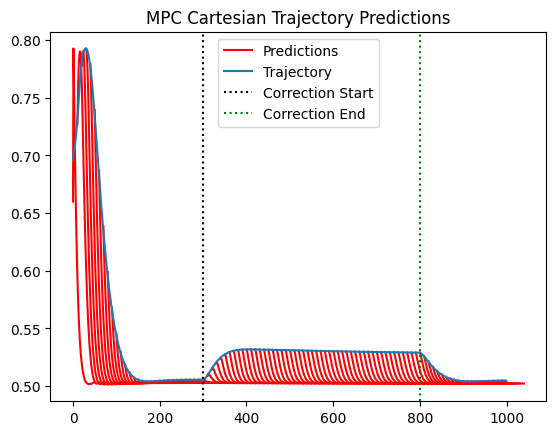

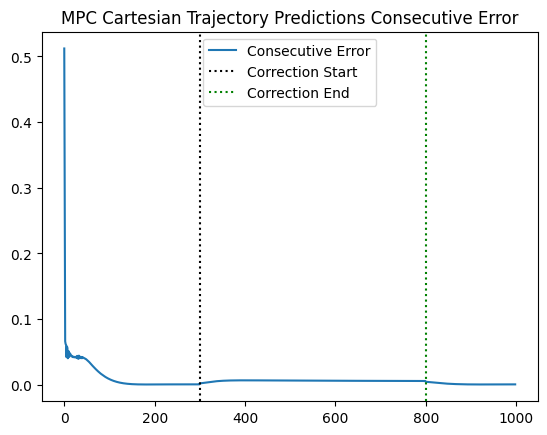

In [169]:
xyz = 2 # 0 for X, 1 for Y, and 2 for Z axes

pose_hist = np.vstack(pose)
for i in range(mpc_cycle):
    if (i%10 == 0):
        t = np.linspace(i,i+T,T+1)
        if i == 0:
            plt.plot(t,sim_data['pose_pred'][i,:,xyz],color='red')
        else:
            plt.plot(t,sim_data['pose_pred'][i,:,xyz],color='red',label='_nolegend_')
plt.plot(pose_hist[:,xyz])
if apply_correction:
    plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
    plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
    plt.legend(['Predictions', 'Trajectory','Correction Start','Correction End'])
else:
    plt.legend(['Predictions', 'Trajectory'])
plt.title('MPC Cartesian Trajectory Predictions')
plt.show()

diff_pred_cart = []
for i in range(mpc_cycle-1):
    cart_prev = sim_data['pose_pred'][i,1:,xyz]
    cart_curr = sim_data['pose_pred'][i+1,:-1,xyz]
    diff_pred_cart.append(np.linalg.norm(cart_prev-cart_curr))
diff_pred_cart = np.stack(diff_pred_cart)
plt.plot(diff_pred_cart)
if apply_correction:
    plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
    plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
    plt.legend(['Consecutive Error','Correction Start','Correction End'])
else:
    plt.legend(['Consecutive Error'])
plt.title('MPC Cartesian Trajectory Predictions Consecutive Error')
plt.show()

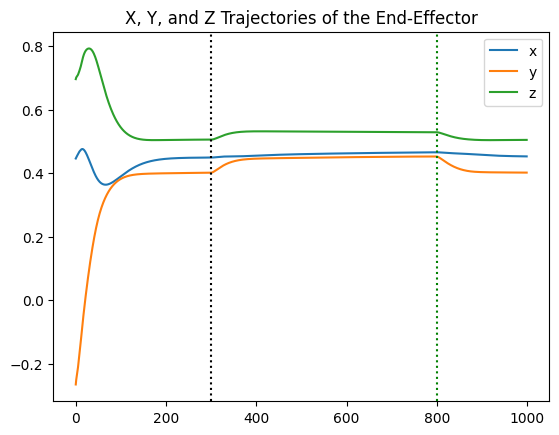

In [170]:
# Plot the X, Y, and Z trajectories of the end-effector
plt.plot(pose_hist)
plt.legend(['x', 'y', 'z'])
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.title('X, Y, and Z Trajectories of the End-Effector')
plt.show()

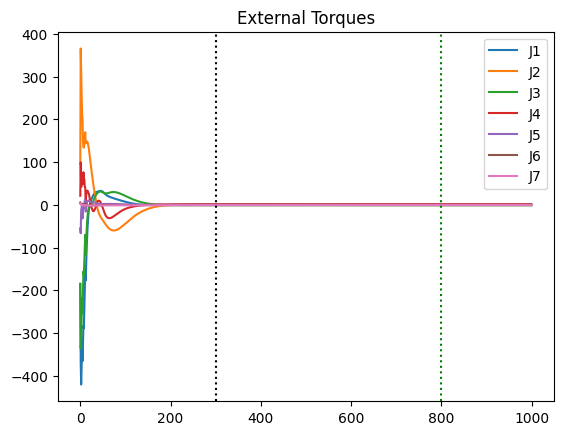

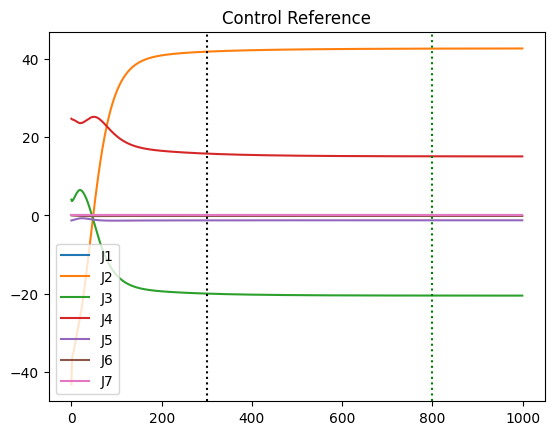

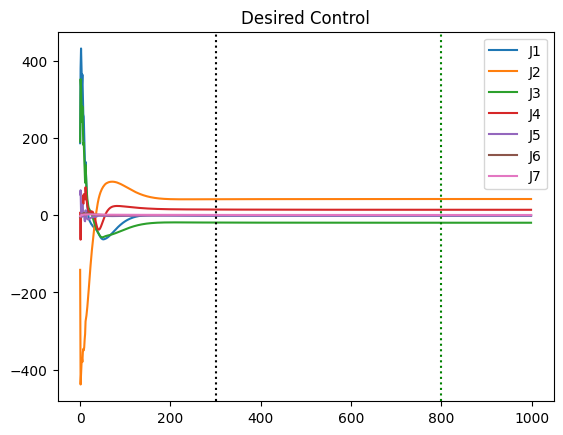

In [144]:
tau_ext = np.stack(tau_ext)
# External Torque Computed as: M*q_ddot + b - tau 
plt.plot(tau_ext)
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.legend(['J1','J2','J3','J4','J5','J6','J7'])
plt.title('External Torques')
plt.show()

# Control Reference
plt.plot(sim_data['ctrl_ref'])
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.legend(['J1','J2','J3','J4','J5','J6','J7'])
plt.title('Control Reference')
plt.show()

# Desired Control
plt.plot(sim_data['ctrl_des_SIM_RATE'])
plt.axvline(x = corr_t_start, color = 'k',linestyle = ':')
plt.axvline(x = corr_t_end, color = 'g',linestyle = ':')
plt.legend(['J1','J2','J3','J4','J5','J6','J7'])
plt.title('Desired Control')
plt.show()


In [20]:
if Mujoco_view:
    pert = np.stack(pert)
div = np.stack(div)
div_q = np.stack(div_q)
div_v = np.stack(div_v)